In [1]:
%load_ext autoreload
%autoreload 2

In [9]:
from subsample import *
import numpy as np
from jax import numpy as jnp
import jax
from pathlib import Path
import pickle
import plotly.express as px
from ott.solvers.quadratic import gromov_wasserstein
from ott.problems.quadratic import quadratic_problem
from ott.solvers.quadratic import lower_bound
from ott.geometry import pointcloud, costs
import seaborn as sns
import matplotlib.pyplot as plt
rng = np.random.default_rng(seed=0)

root_path = Path("../..")
data_path = root_path / "data"

In [3]:
points_array, properties = pickle.load(open(data_path / "halos.pkl", 'rb'))
points_list = [preprocess_pointcloud(p["Coordinates"]) for p in points_array]

In [4]:

def preprocess_pts(pts):
    rec_pts = pts - pts.mean(axis=0, keepdims=True)
    norm_pts = rec_pts / 30
    return norm_pts

def gw_distance(pts_a, pts_b, wghts_a, wghts_b, epsilon=2e0):
    cloud_a = pointcloud.PointCloud(preprocess_pts(pts_a), cost_fn=costs.SqEuclidean())
    cloud_b = pointcloud.PointCloud(preprocess_pts(pts_b), cost_fn=costs.SqEuclidean())

    prob = quadratic_problem.QuadraticProblem(cloud_a, cloud_b, a=wghts_a, b=wghts_b)

    solver = gromov_wasserstein.GromovWasserstein(epsilon=epsilon)

    return solver(prob)


In [24]:
downsample_sizes = [10, 20, 40, 80, 160, 320]
n_trials = 100
ot_costs = jnp.zeros([len(downsample_sizes), n_trials])

point_cloud_a = points_list[1]
point_cloud_b = points_list[2]



for i, downsample_size in tqdm(list(enumerate(downsample_sizes))):
    sampled_point_cloud_a, sampled_weight_a = kmeans_downsample(point_cloud_a, downsample_size, n_trials)
    sampled_point_cloud_b, sampled_weight_b = kmeans_downsample(point_cloud_b, downsample_size, n_trials)
    solns = jax.vmap(gw_distance)(sampled_point_cloud_a, sampled_point_cloud_b, sampled_weight_a, sampled_weight_b)
    ot_costs = ot_costs.at[i].set(solns.reg_gw_cost)

  0%|          | 0/6 [00:00<?, ?it/s]

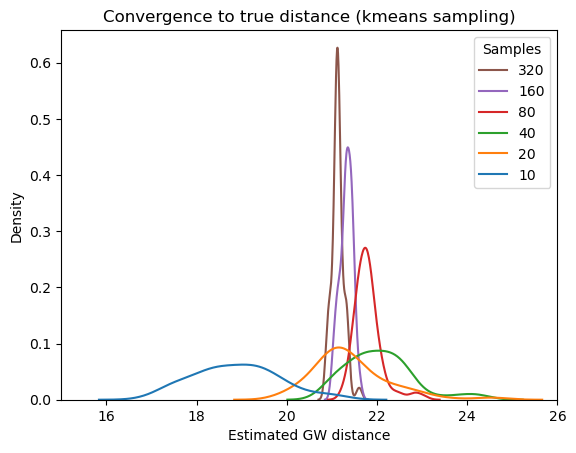

In [30]:
fig, ax = plt.subplots()
sns.kdeplot(ot_costs.T, ax=ax, )
ax.set(xlim=(15, 26), xlabel="Estimated GW distance", title="Convergence to true distance (kmeans sampling)")
ax.legend(np.flip(downsample_sizes), title="Samples")
# ax.hist(ot_costs)